In [7]:
import gc
import time
import umap
import collections
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import torch.nn.functional as F

from SMILE import littleSMILE
from SMILE import littleSMILE_trainer

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

10X multiome PBMC

In [2]:
##Read Modality 1 data
file = "multiome/multiome_gex_processed_training.h5ad"
source = sc.read_h5ad(file)
source.X = source.layers["log_norm"]

sc.pp.highly_variable_genes(source, n_top_genes=3000,subset=True)

rna_rd = source.X.todense()

scaler = StandardScaler()
#scaler = MinMaxScaler((-5,5))
rna_rd = scaler.fit_transform(rna_rd)

feaA = torch.tensor(rna_rd).float()

In [3]:
##Read Modality 2 data
dna = "multiome/multiome_atac_processed_training.csv"
dna = pd.read_csv(dna,index_col=0,header=0)
dna = dna.T
mod2 = sc.AnnData(X=dna)
sc.pp.normalize_total(mod2, target_sum=1e4)
sc.pp.log1p(mod2)

sc.pp.highly_variable_genes(mod2, n_top_genes=3000,subset=True)

dna_rd = mod2.X

scaler = StandardScaler()
#scaler = MinMaxScaler((-5,5))
dna_rd = scaler.fit_transform(dna_rd)

feaB = torch.tensor(dna_rd).float()

In [4]:
gc.collect()

126

In [5]:
##Training little SMILE to identify shared signatures between two modalities
start_time = time.time()

integrater = littleSMILE(input_dim_a=rna_rd.shape[1],input_dim_b=dna_rd.shape[1],clf_out=20)
littleSMILE_trainer(feaA,feaB, integrater, epochs=500)

print("--- %s seconds ---" % int((time.time() - start_time)))

--- 27 seconds ---


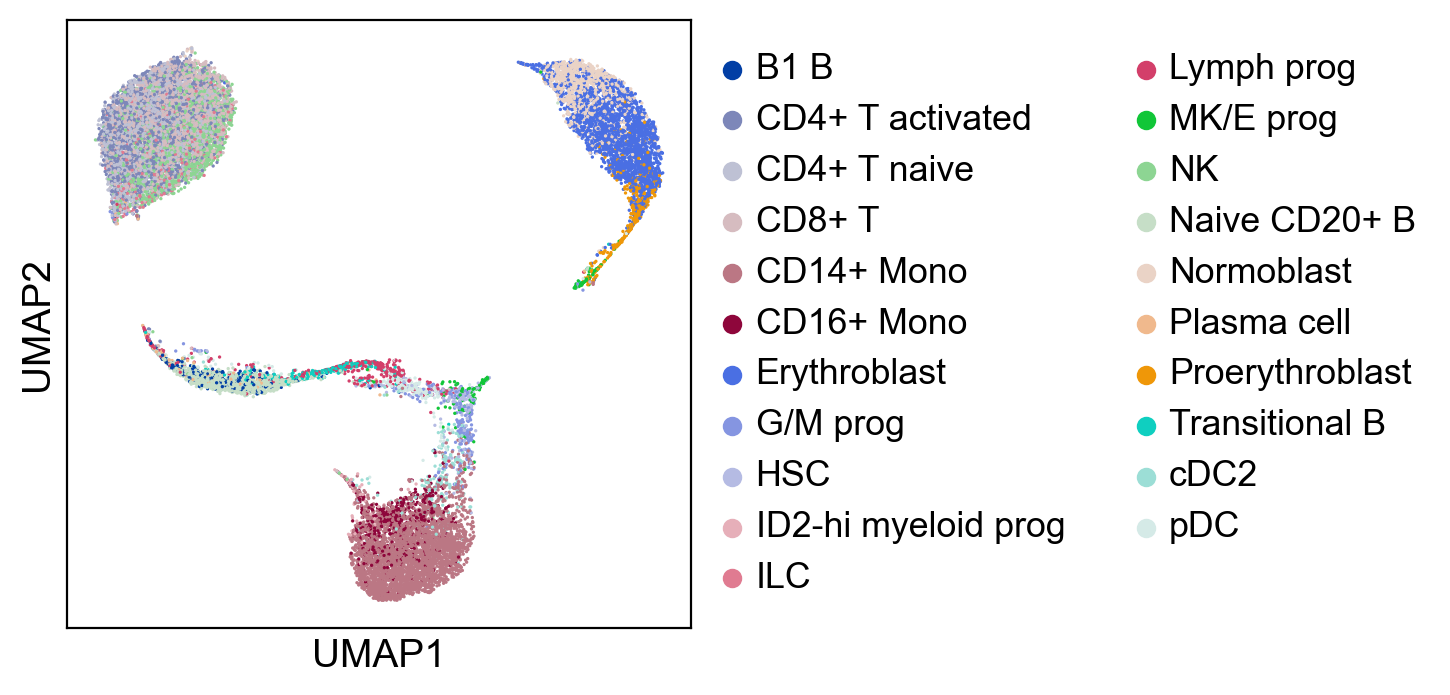

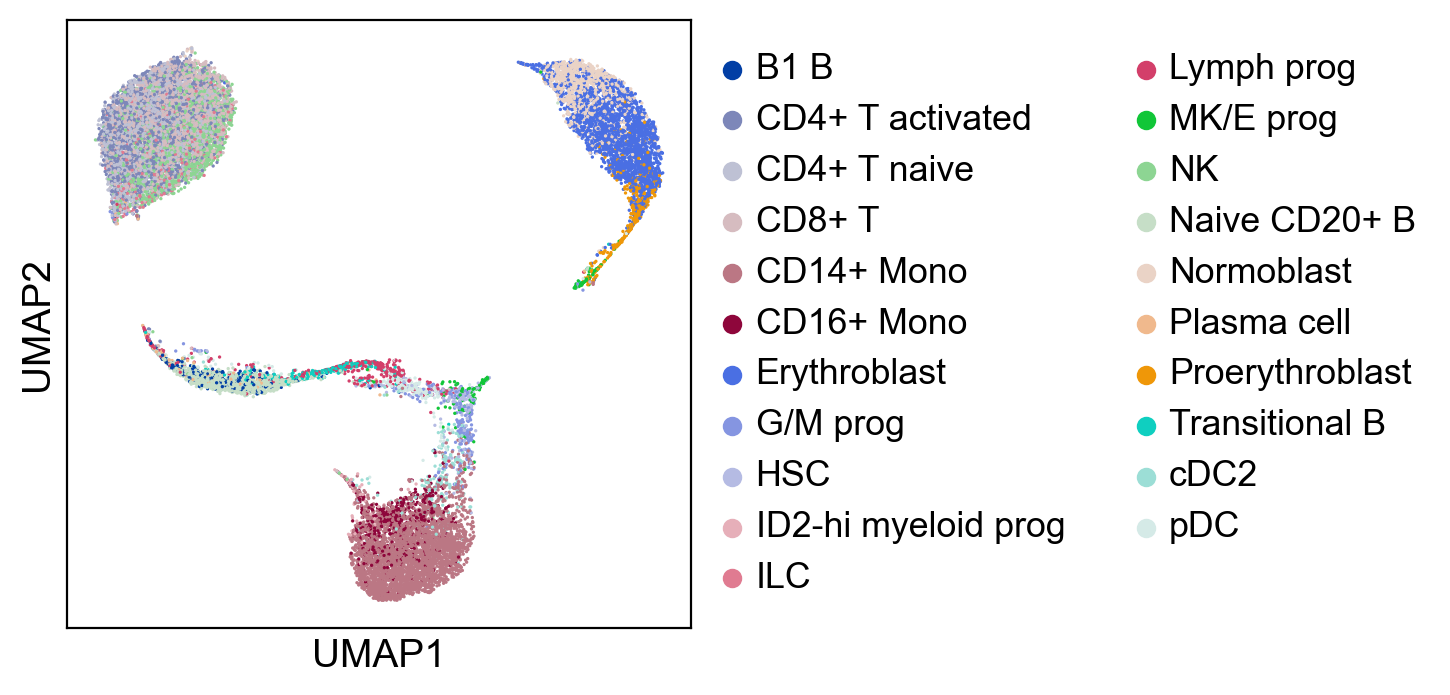

In [41]:
integrater.to(torch.device("cpu"))
X_tensor_A=torch.tensor(rna_rd).float()
X_tensor_B=torch.tensor(dna_rd).float()

za,zb=integrater(X_tensor_A,X_tensor_B)

za = F.normalize(za, dim=1,p=2)
zb = F.normalize(zb, dim=1,p=2)
za = torch.Tensor.cpu(za).detach().numpy()
zb = torch.Tensor.cpu(zb).detach().numpy()

y_pred = (za+zb)/2

umaps = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2,
                  metric="cosine").fit(y_pred)

embedding = umaps.transform(y_pred)
embedding = pd.DataFrame(embedding)

##Visualization for Modality 1 via UMAP
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)
source.obsm['X_umap']=embedding.iloc[:,:2].values
sc.pl.umap(source, color='cell_type', title='')

##Visualization for Modality 2 via UMAP
mod2.obsm['X_umap']=embedding.iloc[:,:2].values
mod2.obs['cell_type']=source.obs['cell_type'].values
sc.pl.umap(mod2, color='cell_type', title='')

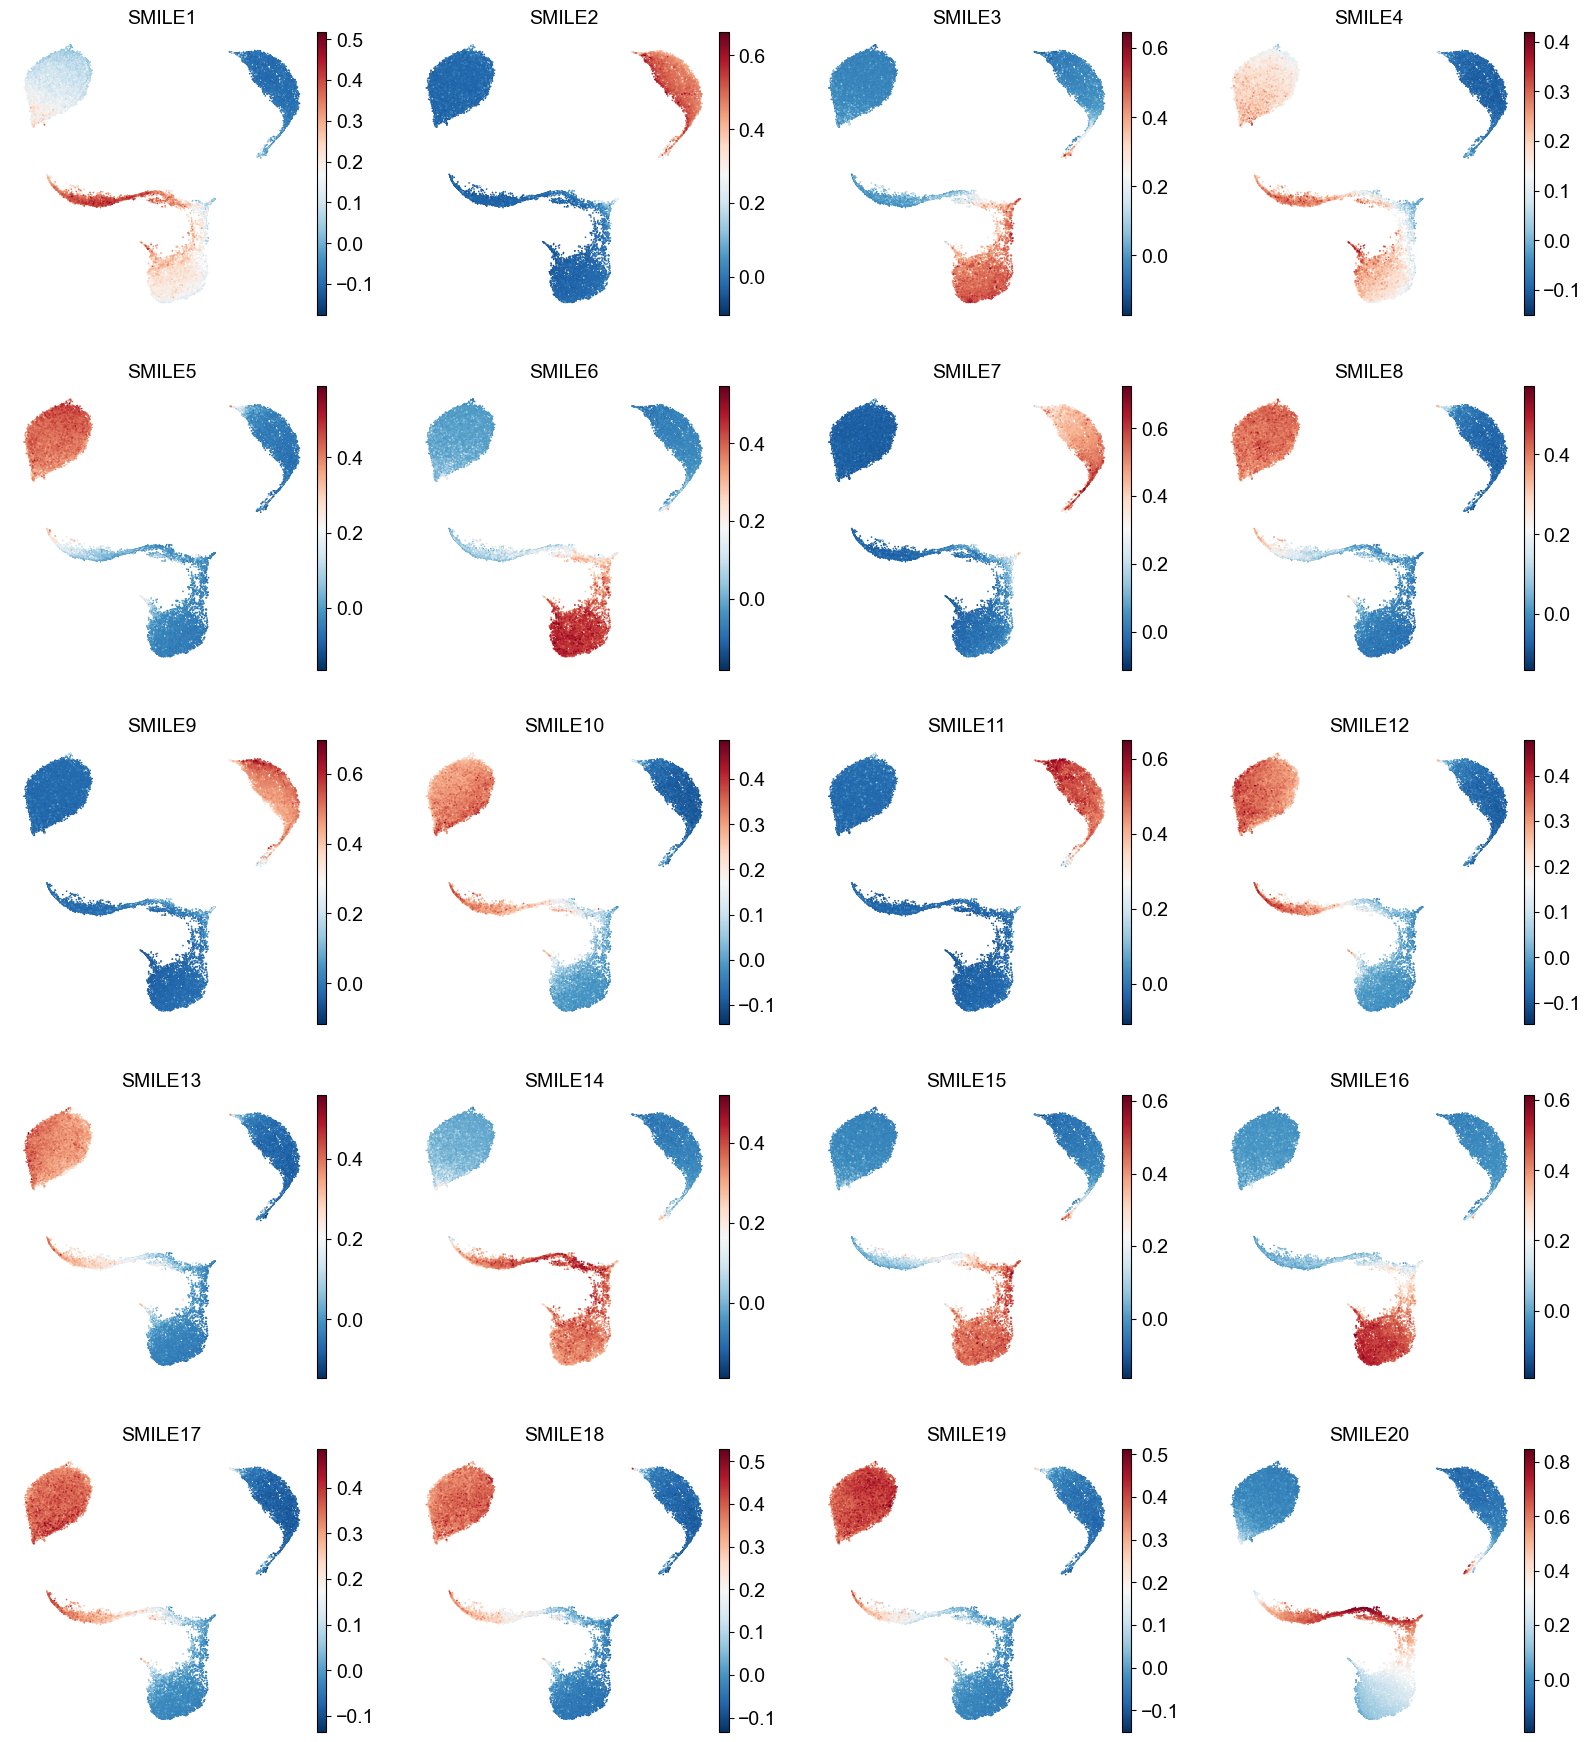

In [12]:
##Visualization of latent space via UMAP
dims = ['SMILE'+str(i) for i in range(1,21)]
for i in range(1,21):
    mod2.obs['SMILE'+str(i)]=y_pred[:,i-1]
    
sc.set_figure_params(scanpy=True, dpi=50, dpi_save=50)
sc.pl.umap(mod2, color=dims,ncols=4, frameon=False,cmap='RdBu_r')

In [13]:
##Weights extraction
weights=[]
for p in integrater.encoder_a.parameters():
    weights.append(p)
weightsA=torch.Tensor.cpu(weights[0]).detach().numpy()
weightsA = pd.DataFrame(weightsA.T)
weightsA.columns = dims
weightsA.index = source.var.index

weights=[]
for p in integrater.encoder_b.parameters():
    weights.append(p)
weightsB=torch.Tensor.cpu(weights[0]).detach().numpy()
weightsB = pd.DataFrame(weightsB.T)
weightsB.columns = dims
weightsB.index = mod2.var.index

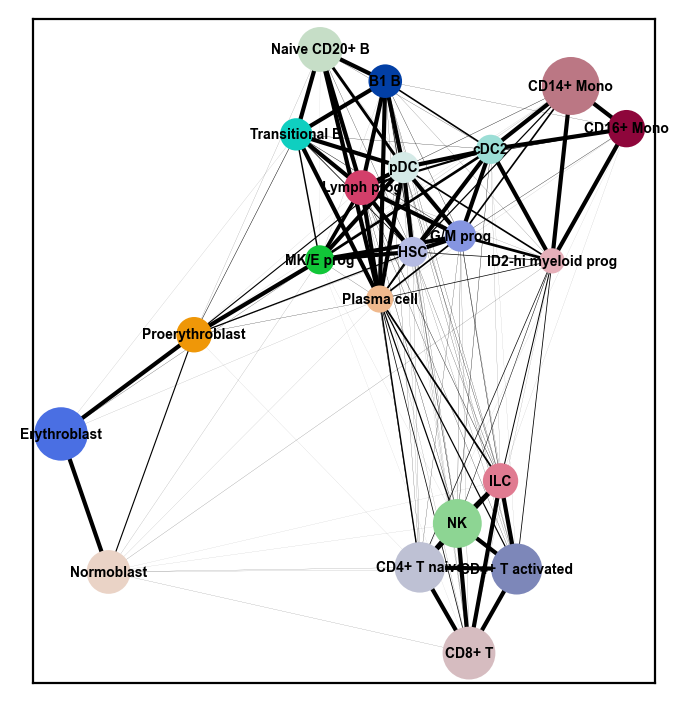

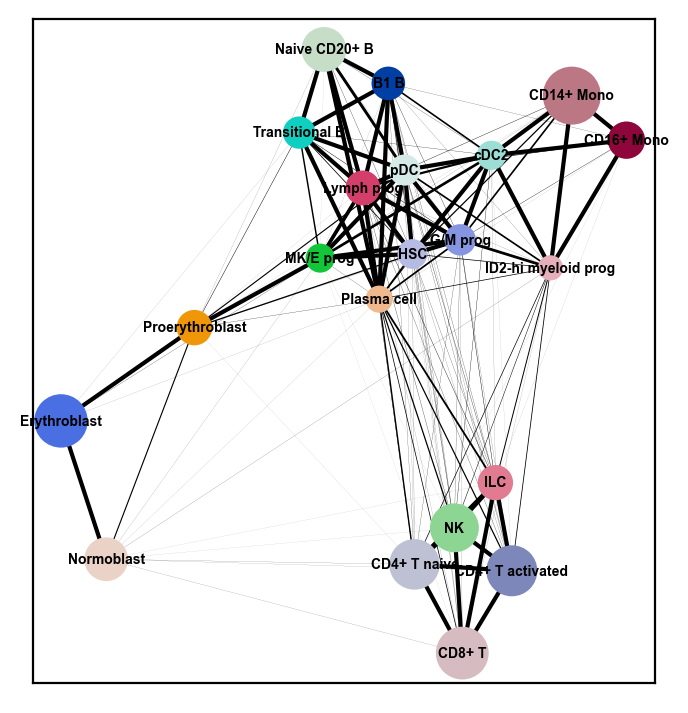

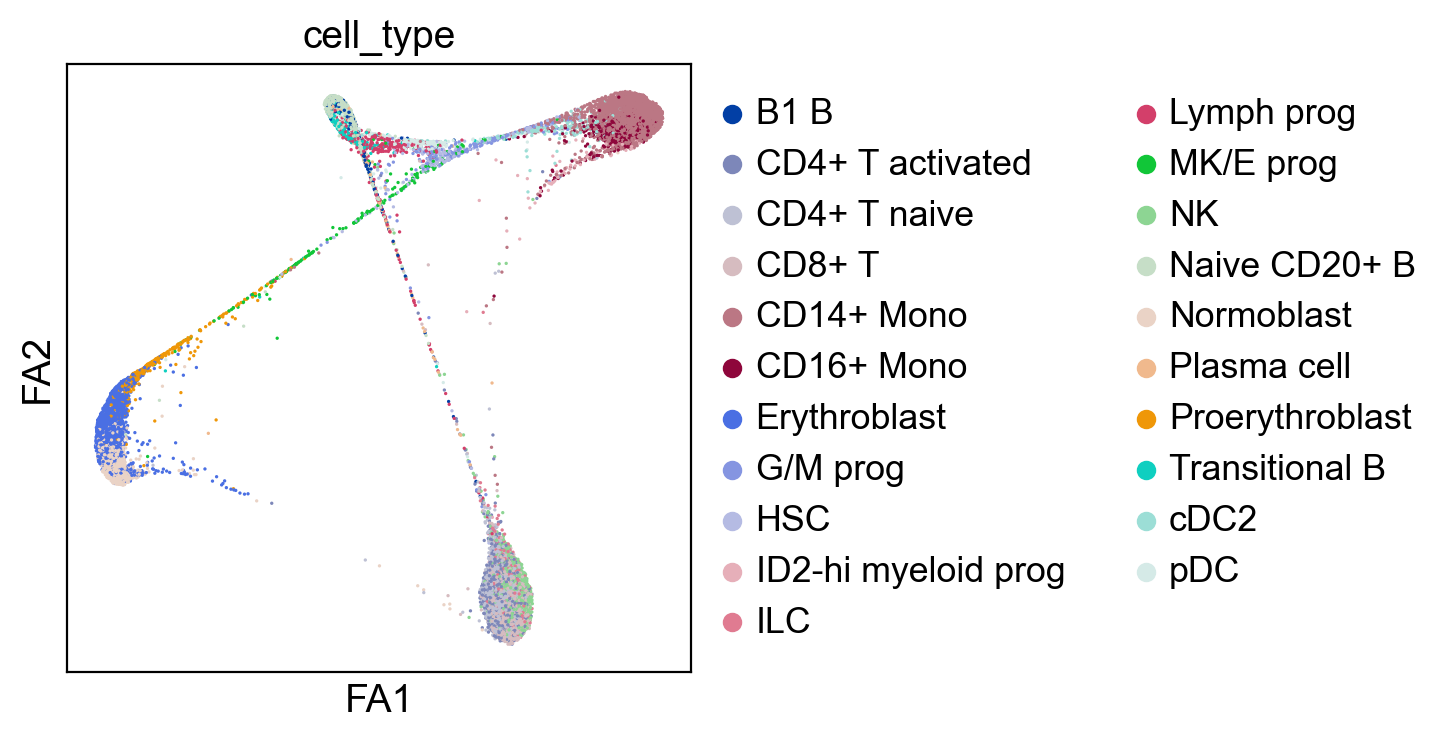

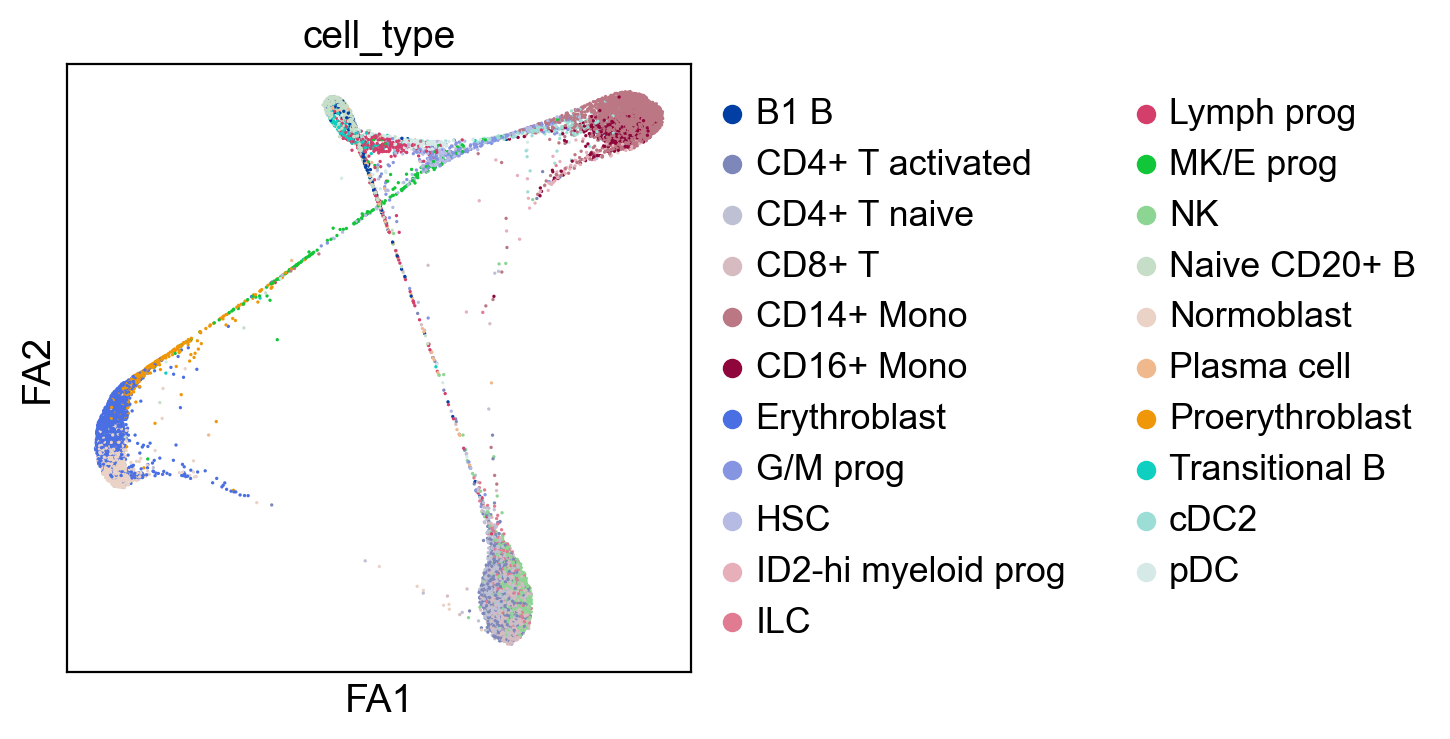

In [27]:
##Relay out cells using PAGA for visualizaton
source.obsm['X_smile']=y_pred
sc.pp.neighbors(source, n_neighbors=10, use_rep='X_smile',metric='cosine')
mod2.obsm['X_smile']=y_pred
sc.pp.neighbors(mod2, n_neighbors=10, use_rep='X_smile',metric='cosine')

sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)

sc.tl.paga(source, groups='cell_type')
sc.pl.paga(source, color=['cell_type'],threshold=0.01, show=False,edge_width_scale=0.2,fontsize=5)
sc.tl.paga(mod2, groups='cell_type')
sc.pl.paga(mod2, color=['cell_type'],threshold=0.01, show=False,edge_width_scale=0.2,fontsize=5)

sc.tl.draw_graph(source, init_pos='paga')
sc.tl.draw_graph(mod2, init_pos='paga')
sc.pl.draw_graph(source, color=['cell_type'])
sc.pl.draw_graph(mod2, color=['cell_type'])

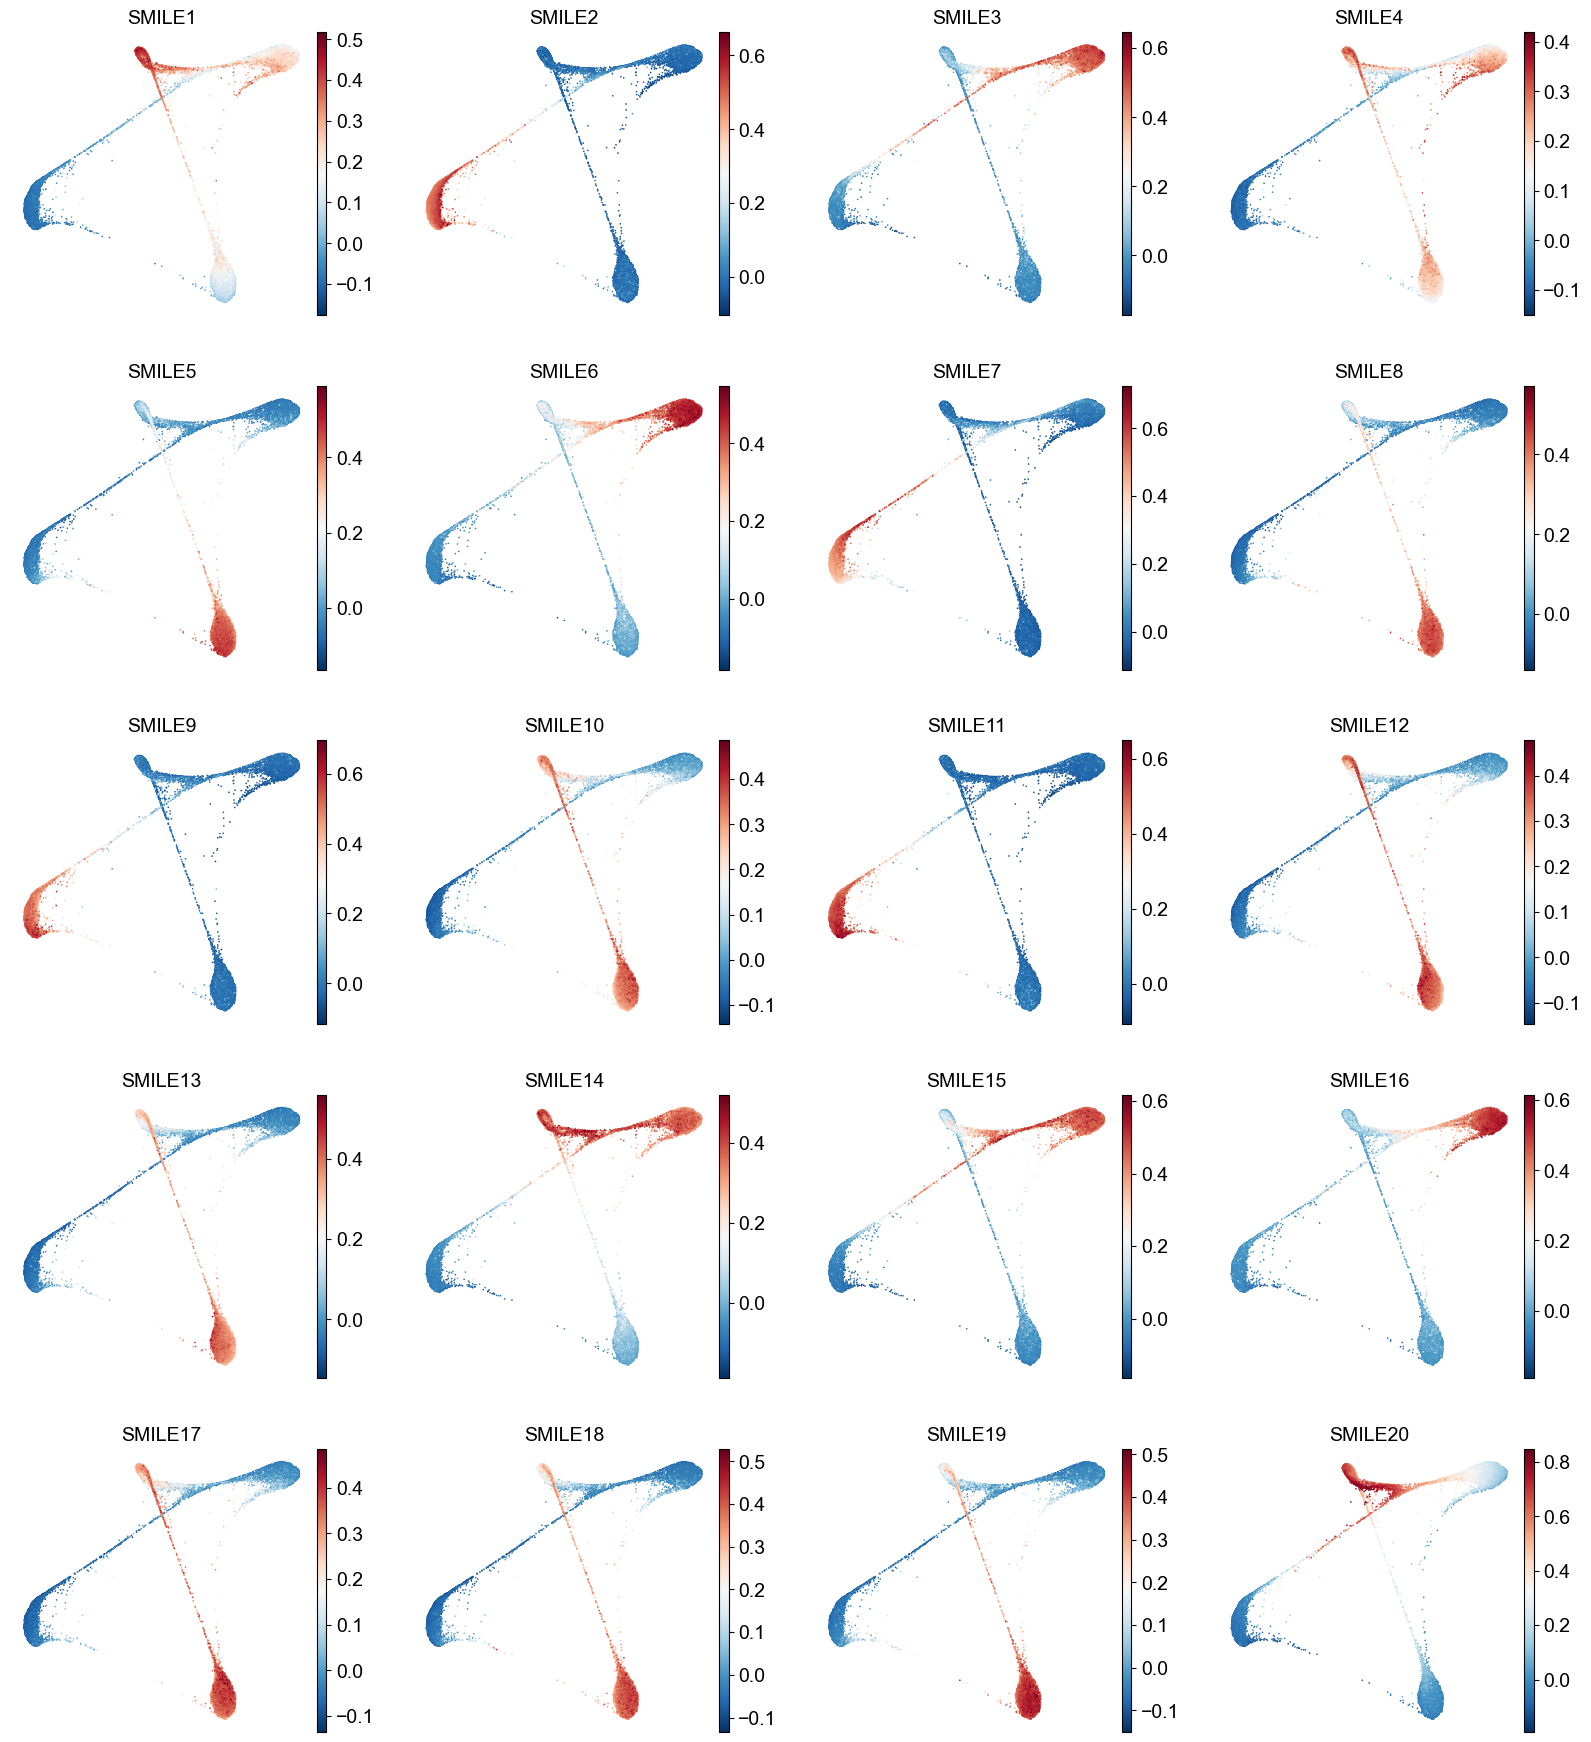

In [28]:
sc.set_figure_params(scanpy=True, dpi=50, dpi_save=50)
sc.pl.draw_graph(mod2, color=dims,ncols=4, frameon=False,cmap='RdBu_r')

In [29]:
mod2.layers['scaled'] = sc.pp.scale(mod2, copy=True).X
source.layers['scaled'] = sc.pp.scale(source, copy=True).X

In [30]:
##Evaluate Dim #7
smileA = weightsA['SMILE7'].sort_values(ascending = False)
smileB = weightsB['SMILE7'].sort_values(ascending = False)

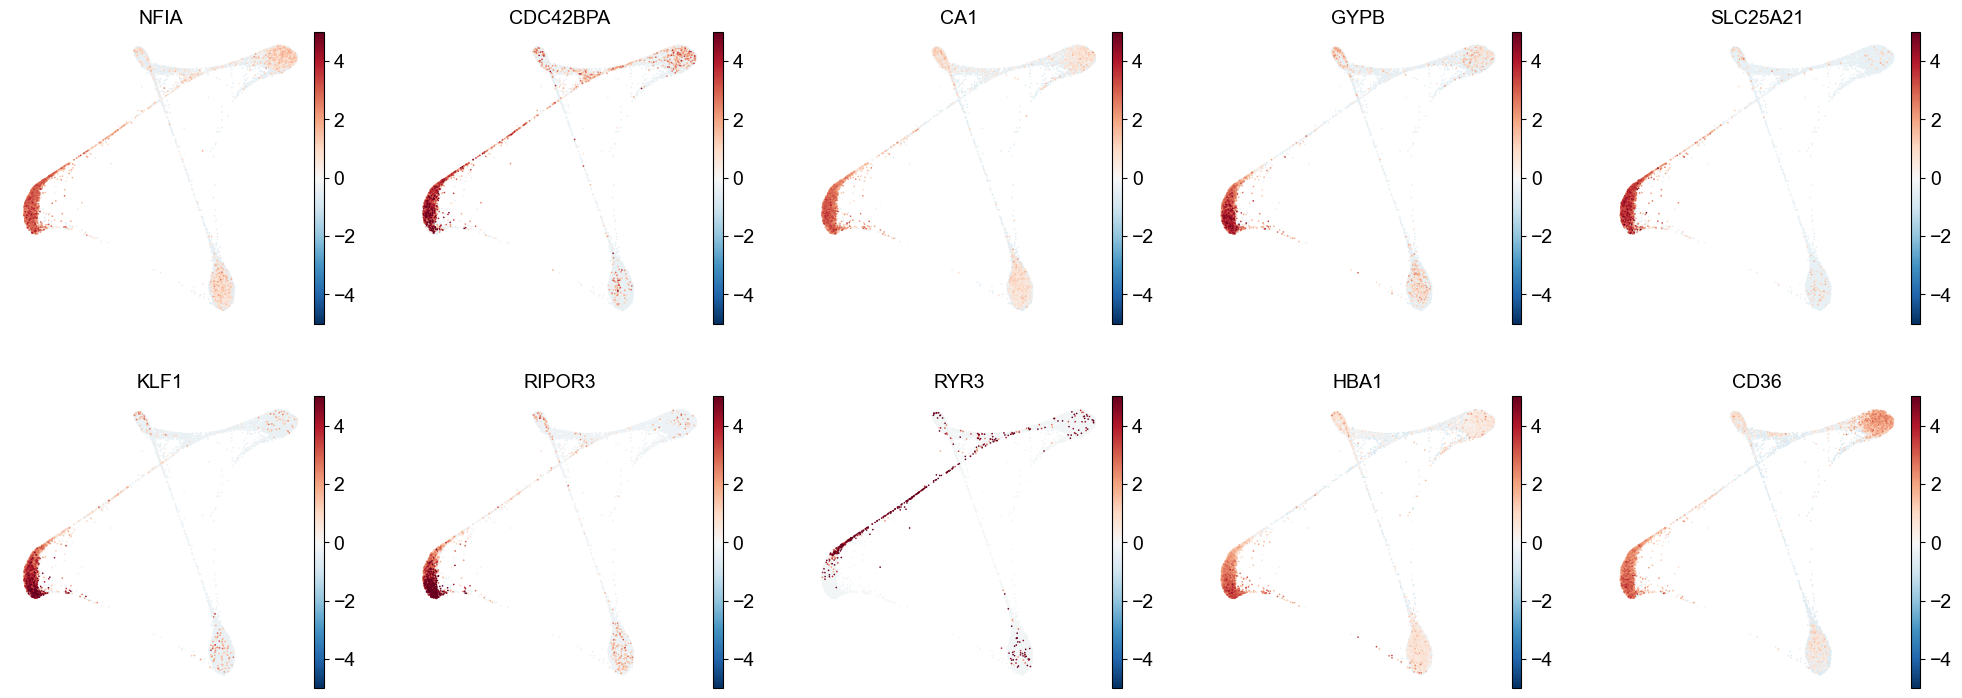

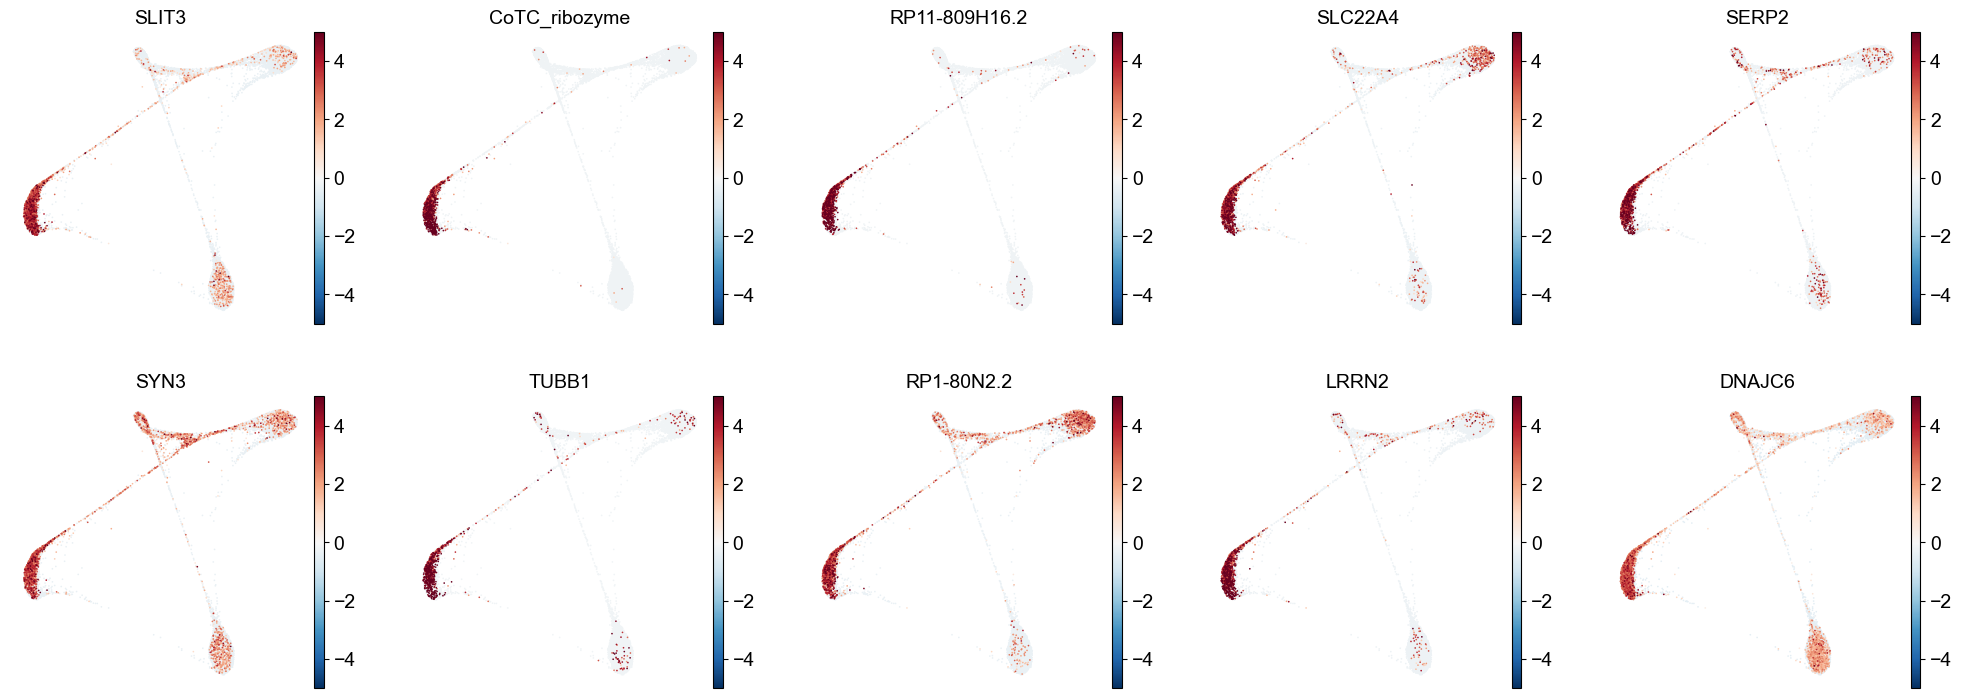

In [32]:
##Positive shared signatures
sc.set_figure_params(scanpy=True, dpi=50, dpi_save=50)
sc.pl.draw_graph(source, color=smileA.index[:10],ncols=5, frameon=False,cmap='RdBu_r',layer='scaled', vmin=-5, vmax=5)
sc.pl.draw_graph(mod2, color=smileB.index[:10],ncols=5, frameon=False,cmap='RdBu_r',layer='scaled', vmin=-5, vmax=5)

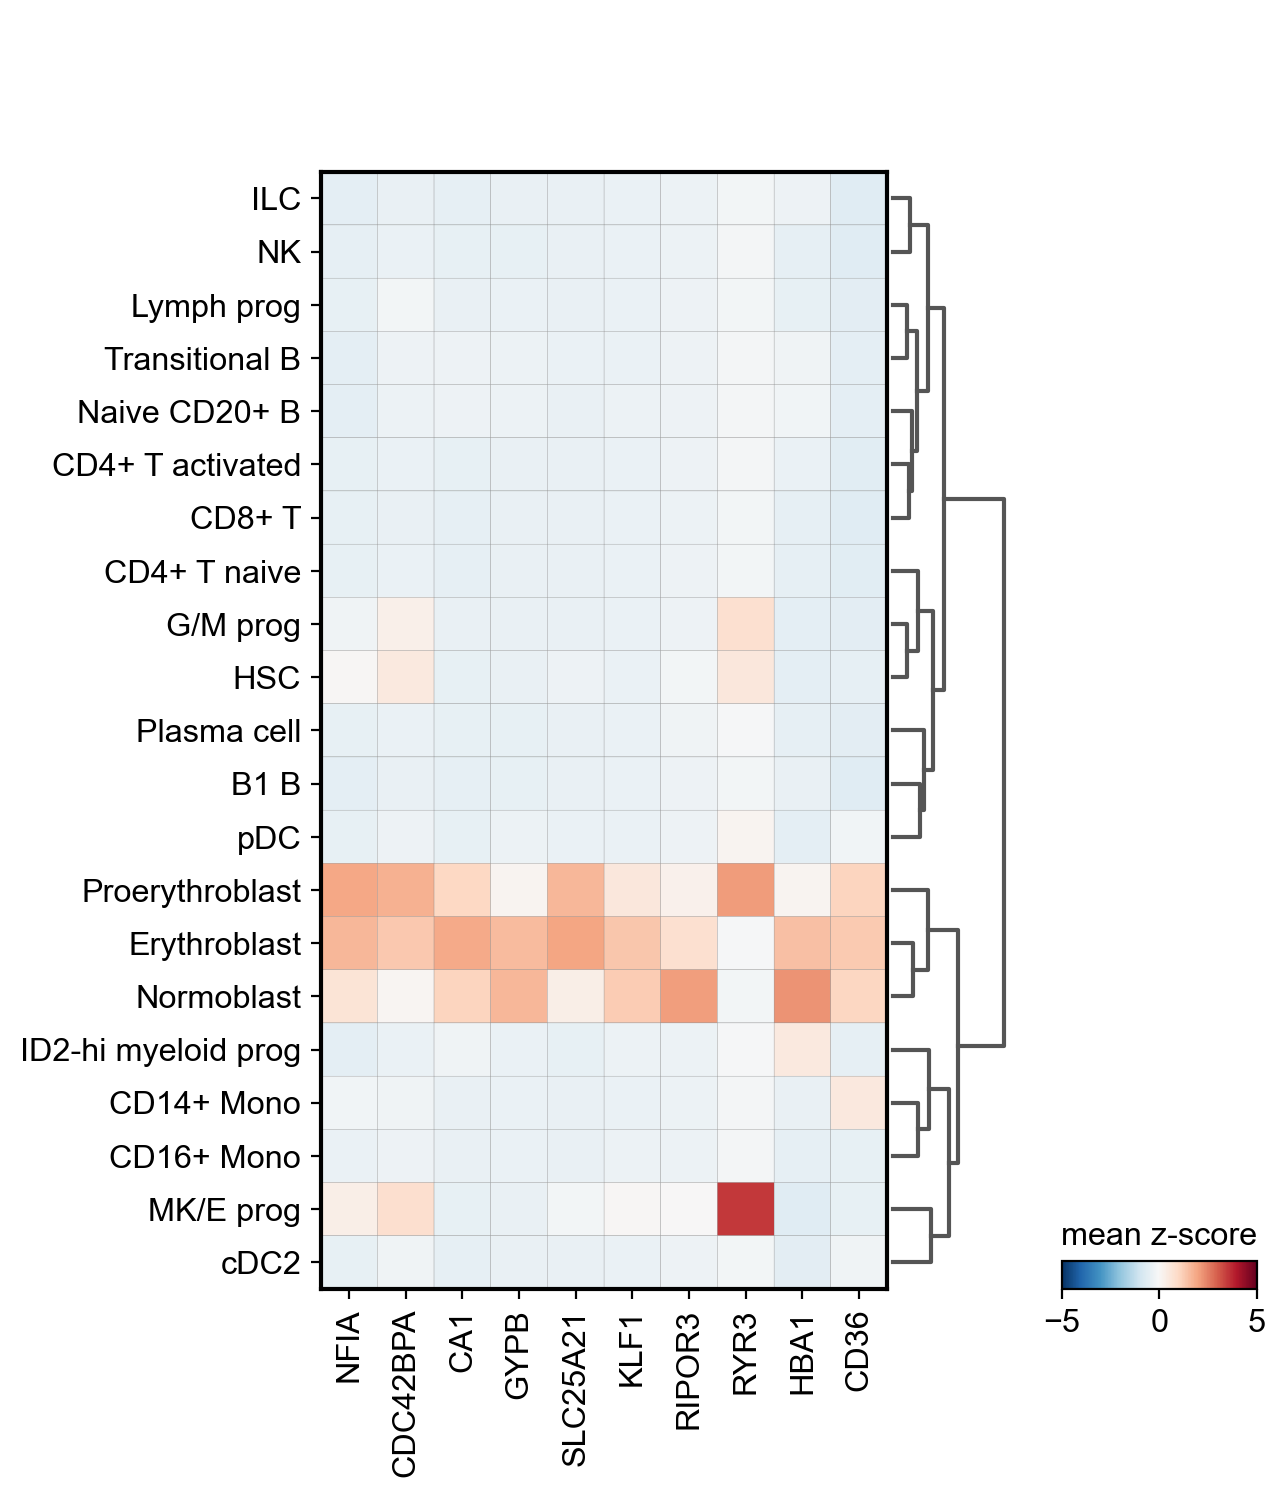

         Falling back to preprocessing with `sc.pp.pca` and default params.


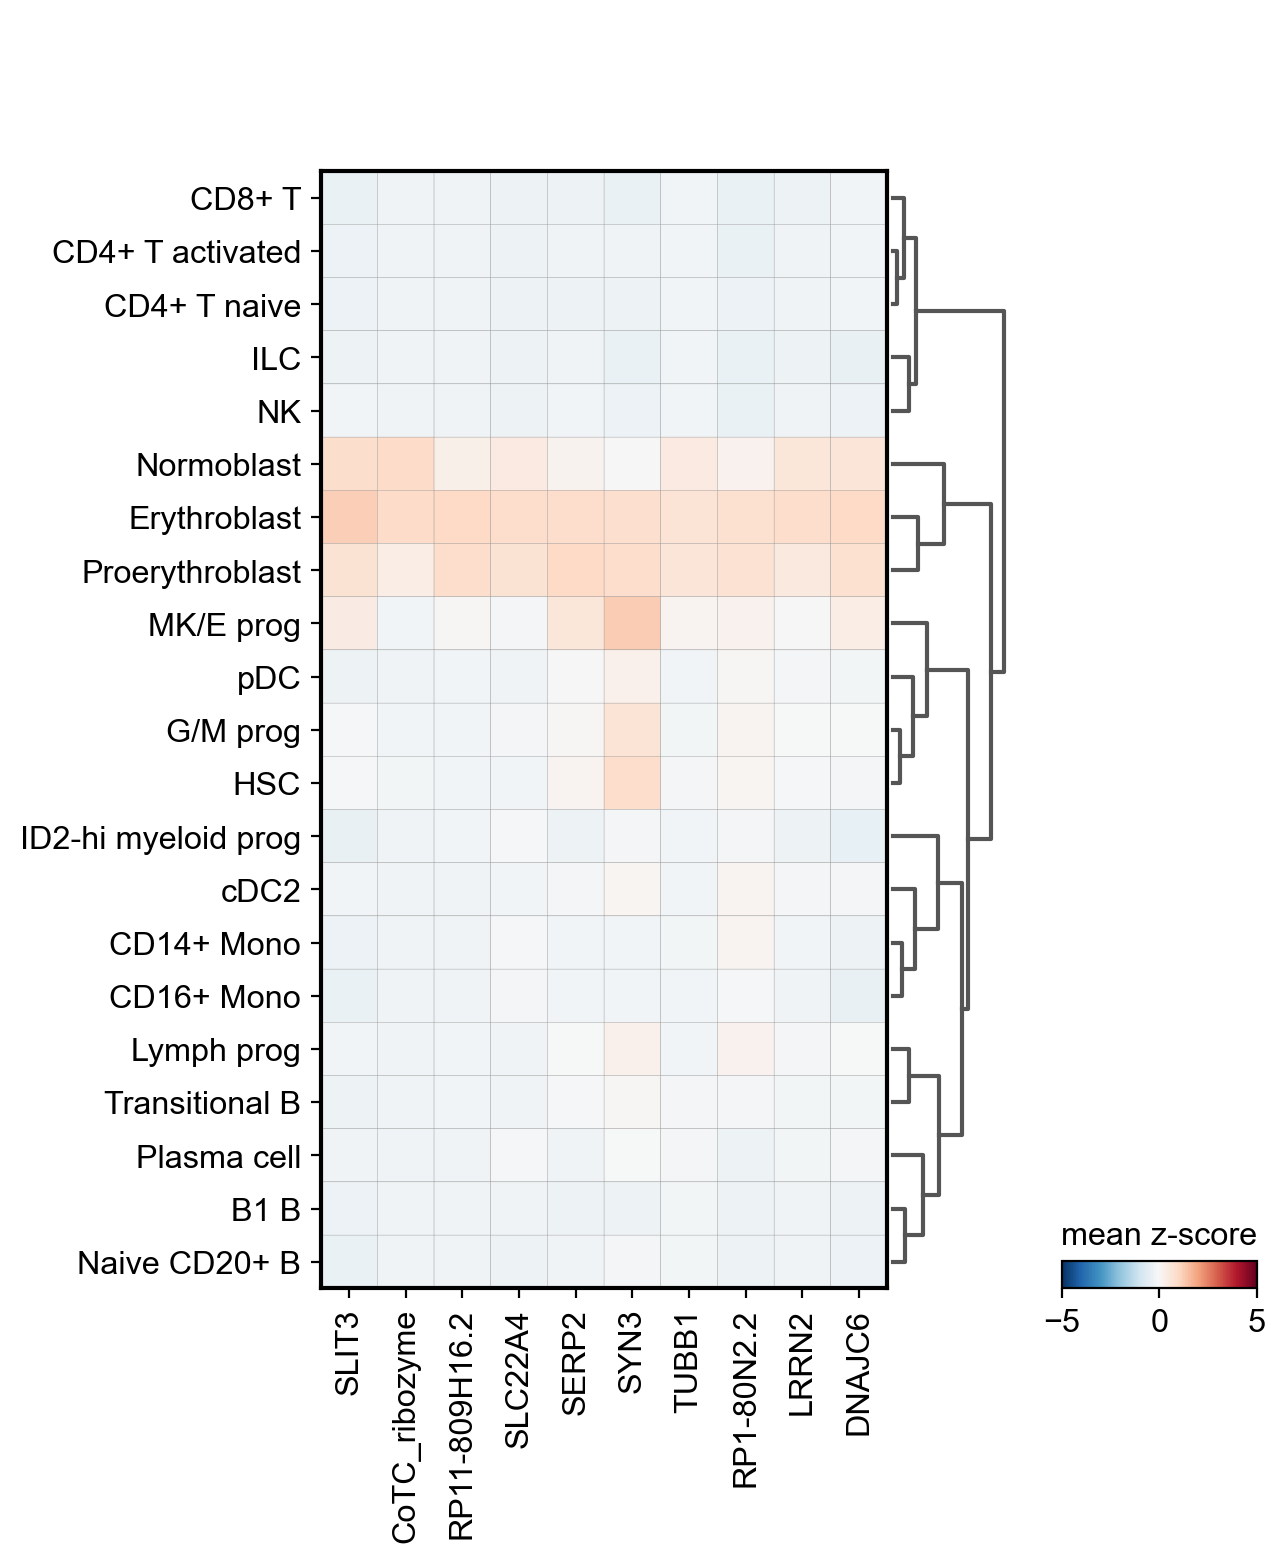

In [33]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)
sc.pl.matrixplot(source, smileA.index[:10], 'cell_type', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-5, vmax=5, cmap='RdBu_r')
sc.pl.matrixplot(mod2, smileB.index[:10], 'cell_type', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-5, vmax=5, cmap='RdBu_r')

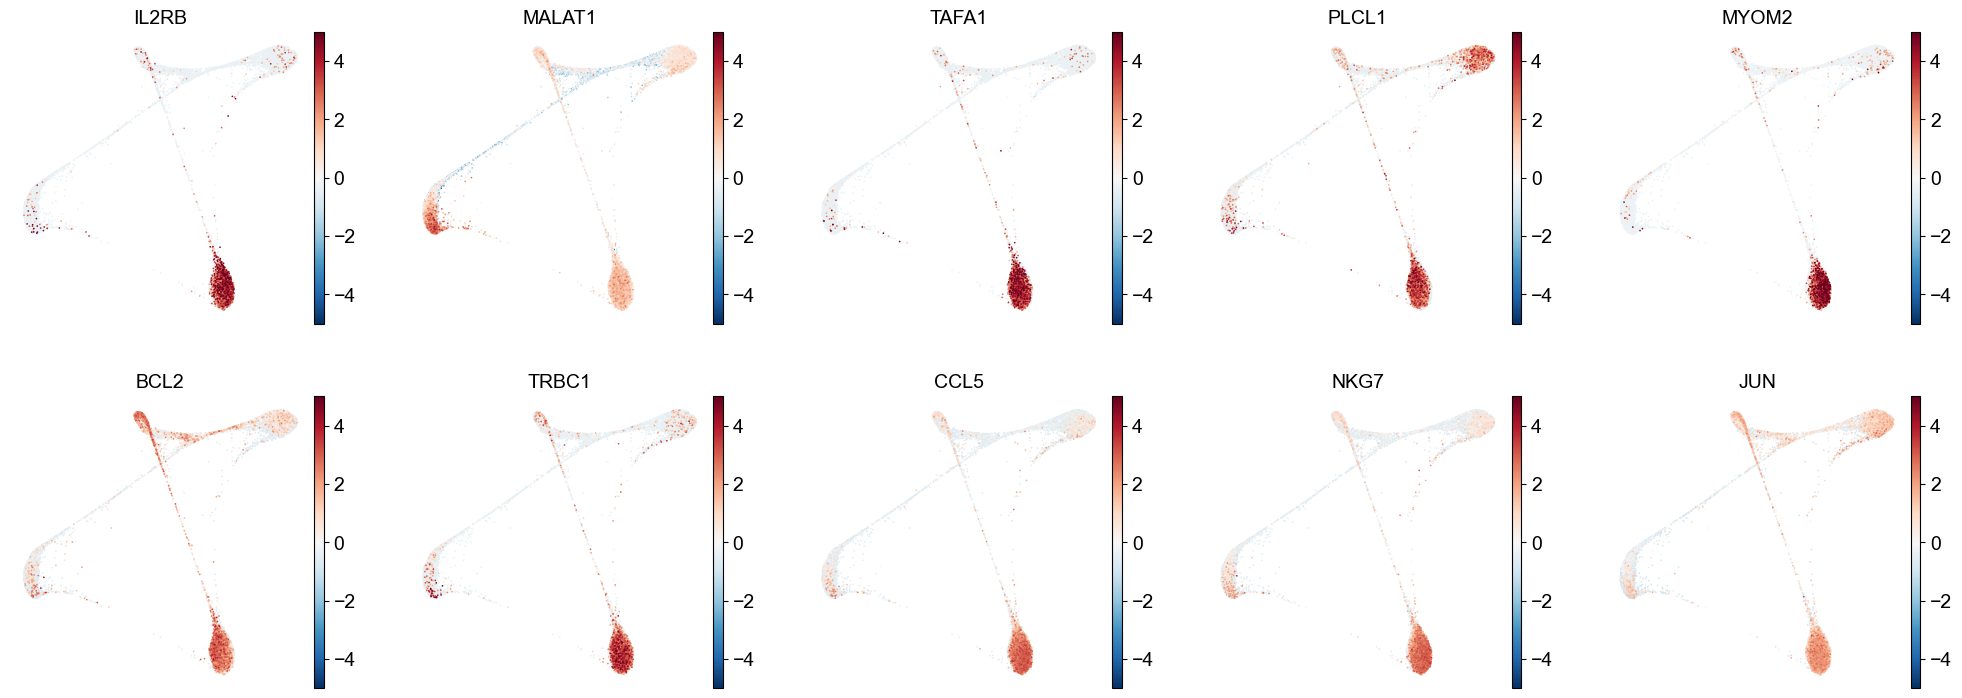

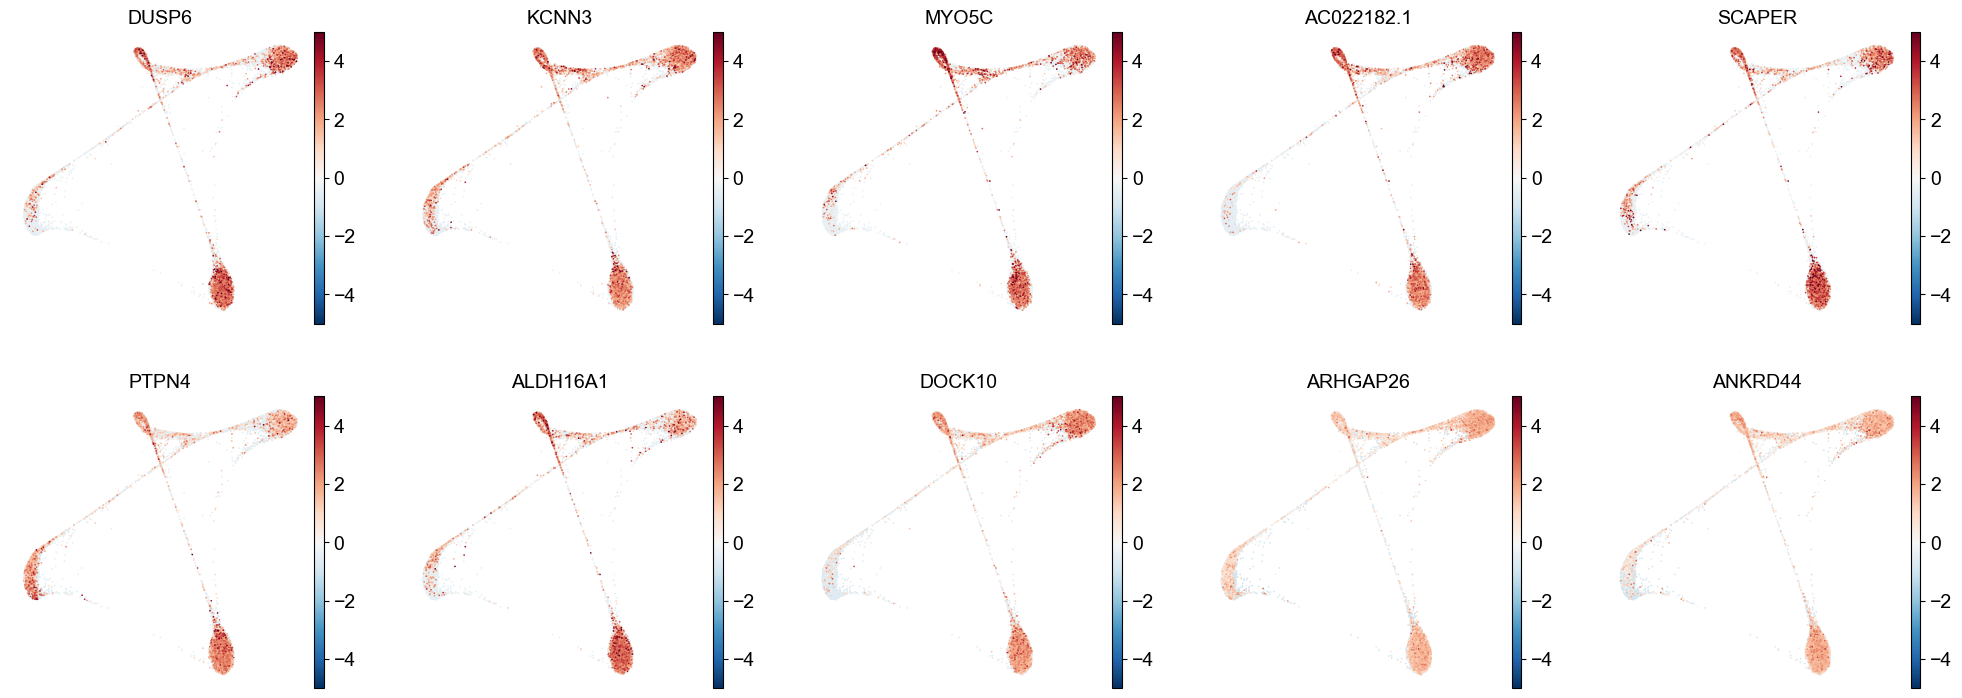

In [34]:
##Negative shared signatures
sc.set_figure_params(scanpy=True, dpi=50, dpi_save=50)
sc.pl.draw_graph(source, color=smileA.index[-10:],ncols=5, frameon=False,cmap='RdBu_r',layer='scaled', vmin=-5, vmax=5)
sc.pl.draw_graph(mod2, color=smileB.index[-10:],ncols=5, frameon=False,cmap='RdBu_r',layer='scaled', vmin=-5, vmax=5)

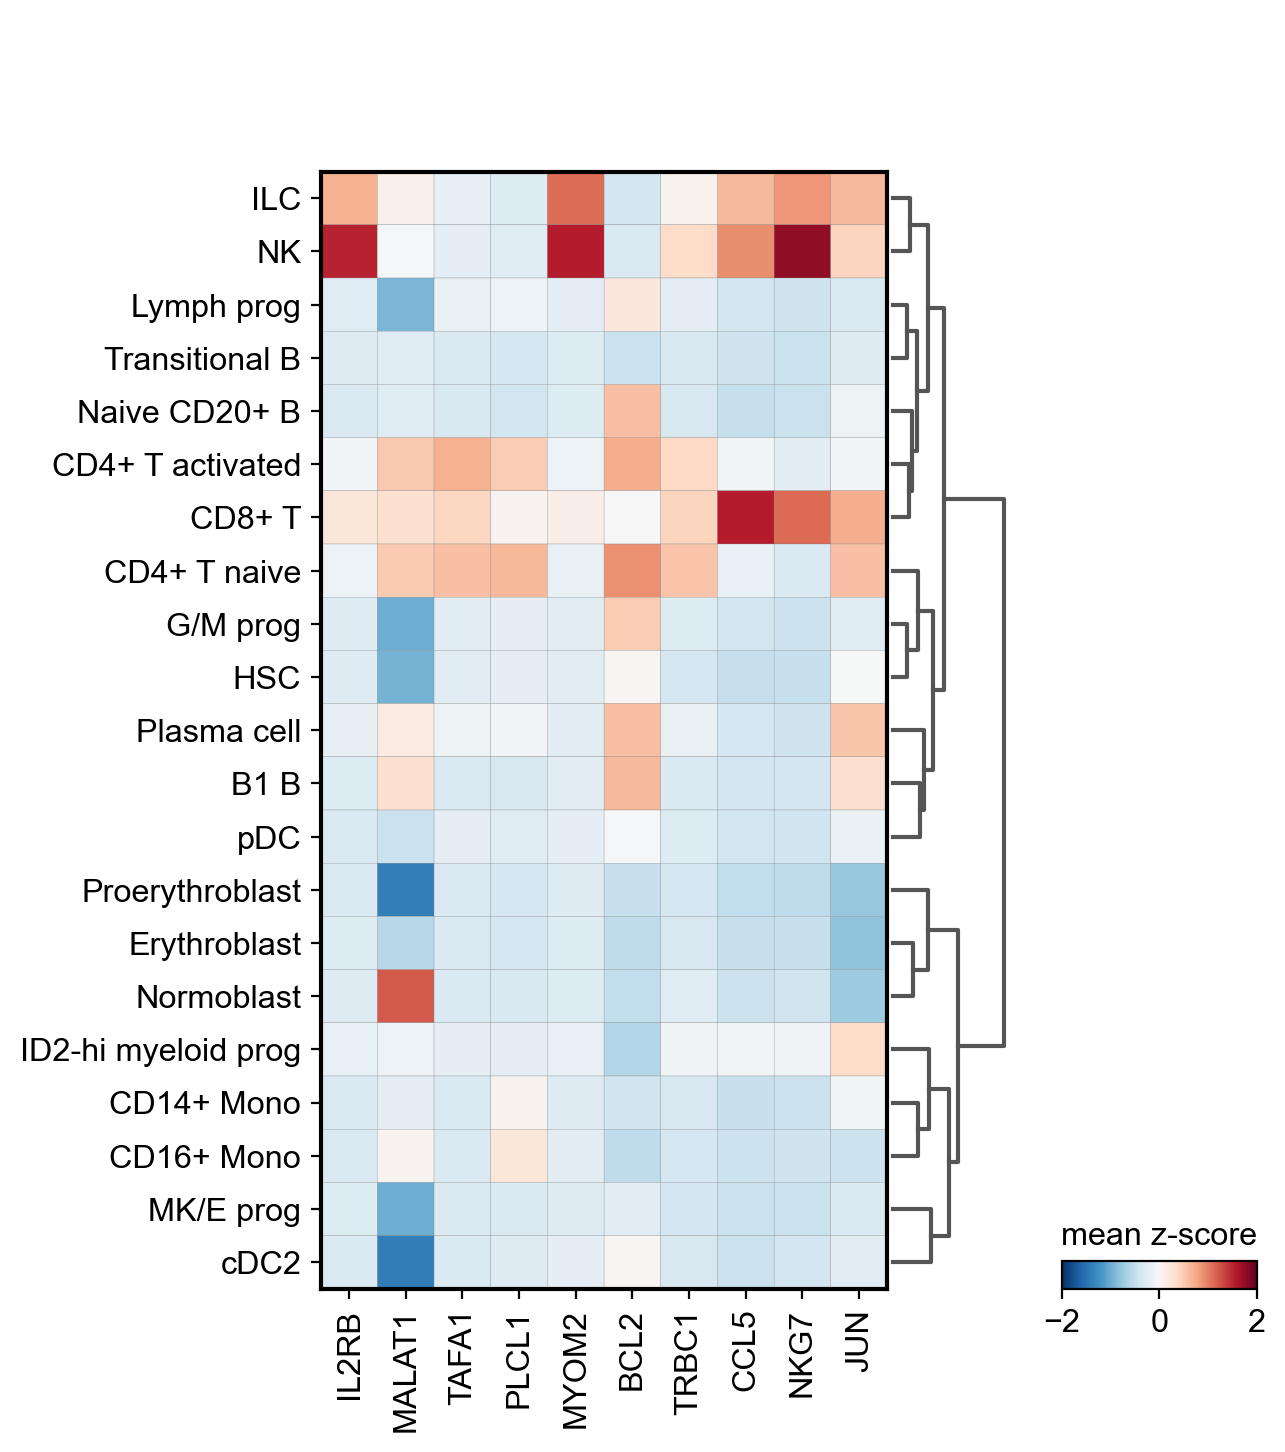

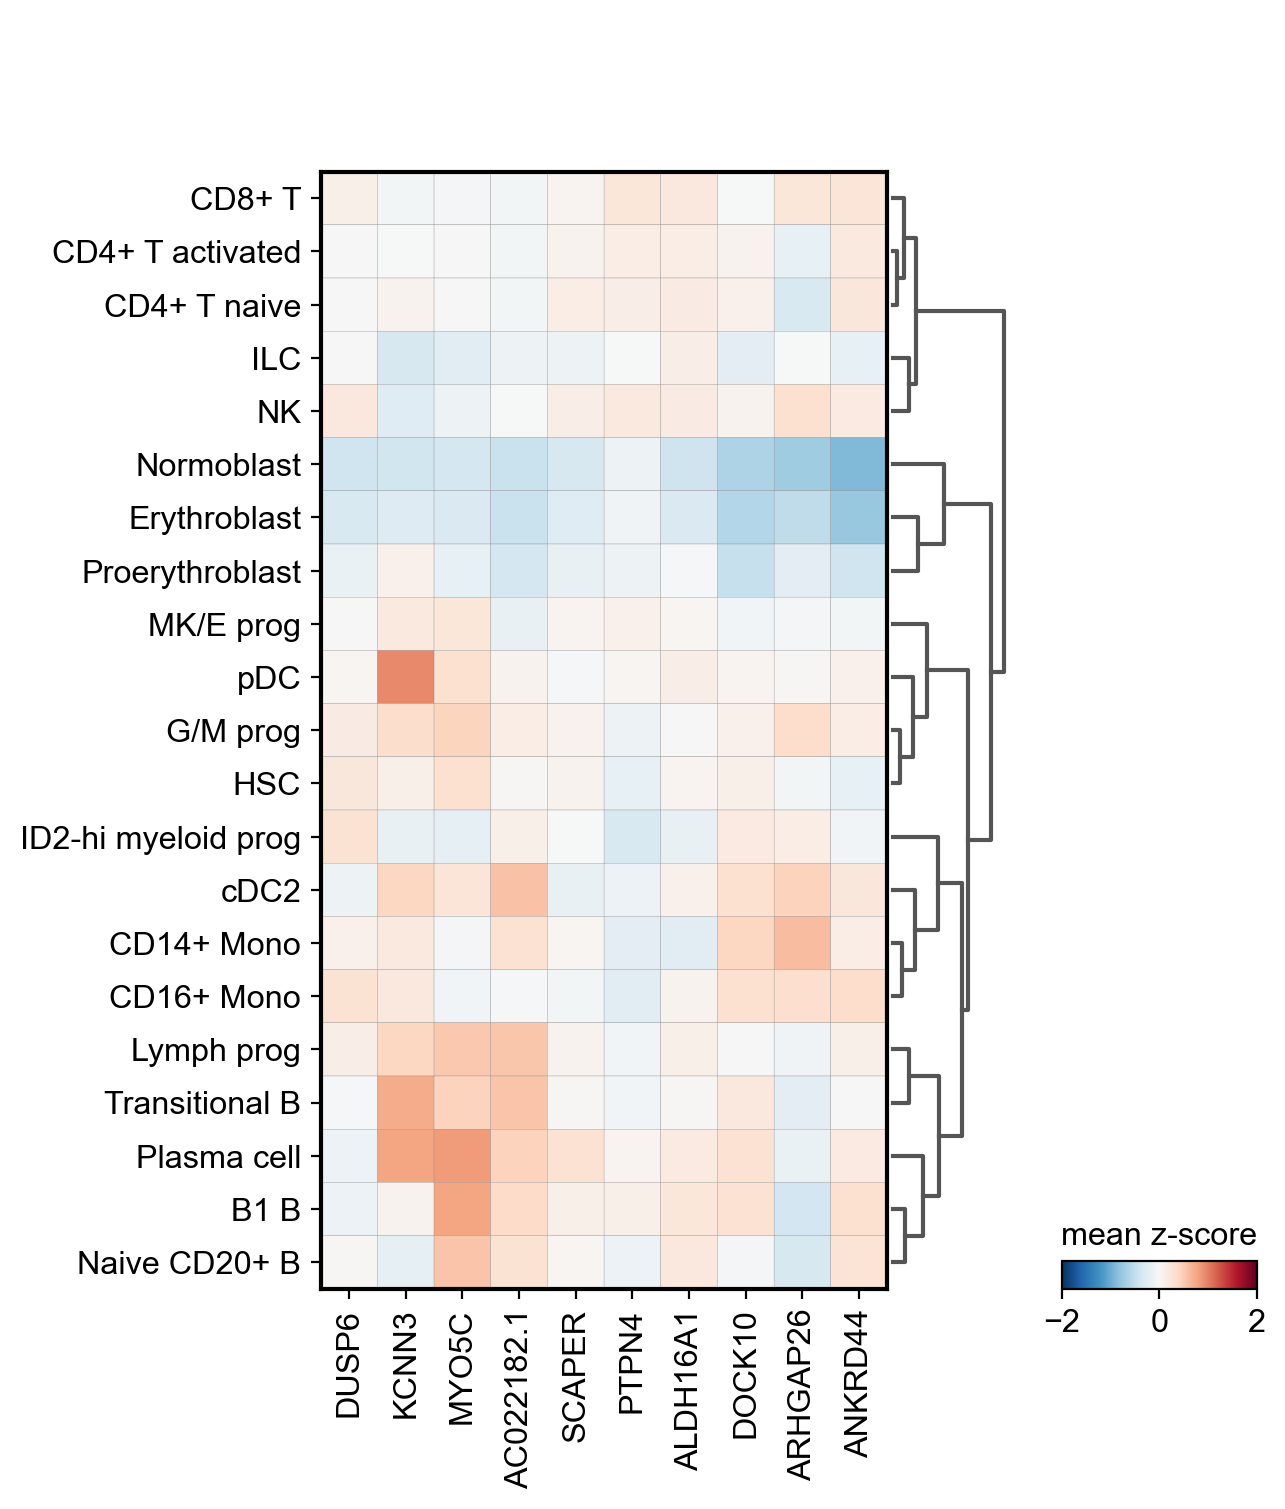

In [38]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)
sc.pl.matrixplot(source, smileA.index[-10:], 'cell_type', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')
sc.pl.matrixplot(mod2, smileB.index[-10:], 'cell_type', dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')

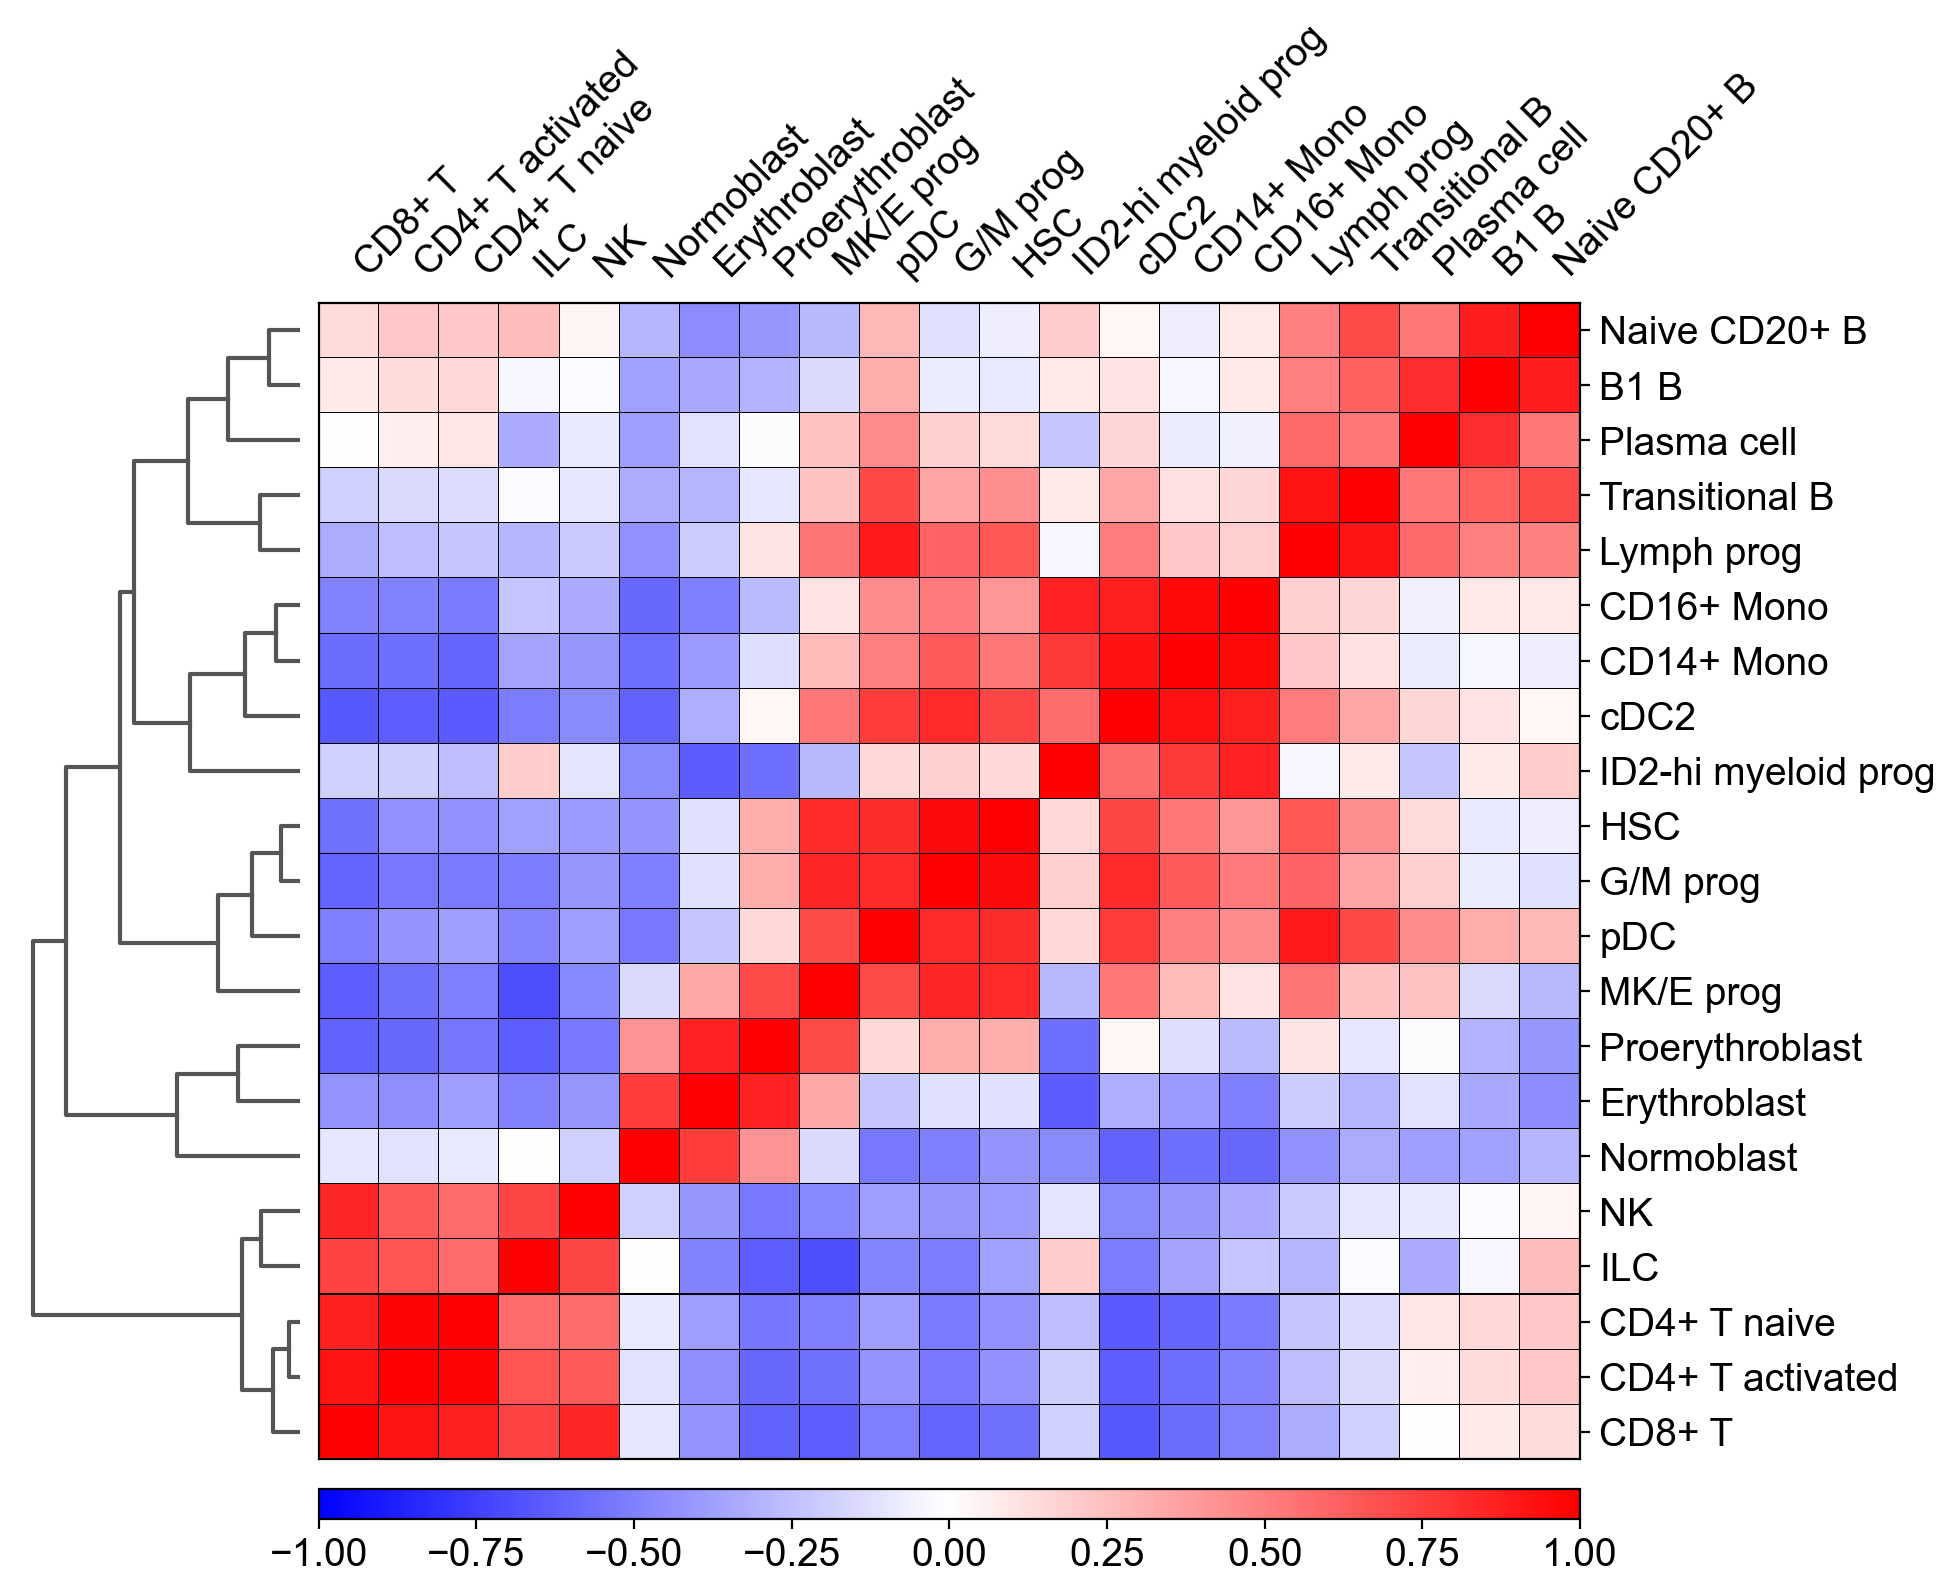

In [40]:
mod2.obs['Annotation']= pd.Series(mod2.obs['cell_type'], dtype="category").values
sc.tl.dendrogram(mod2, 'Annotation', use_rep='X_smile',cor_method='spearman', linkage_method='ward')
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=100)
sc.pl.correlation_matrix(mod2, 'Annotation', figsize=(10,8))